
# MSU spectra handling (2D mapping)


In [1]:
# Author: Rinat R. Ismagilov <ismagil@polly.phys.msu.ru>
#
# License: GNU General Public License v3.0

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import time 
%matplotlib inline

pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.1f}'.format


import sys
sys.path.append("..")

from utils.pyOESconsts import Consts
from utils.SpectrumModifier import SpectrumModifier

modifier = SpectrumModifier()

In [2]:
# nice practice

%load_ext version_information

%version_information numpy, pandas, matplotlib, sklearn, version_information


Software versions
Python 3.5.2 64bit [MSC v.1900 64 bit (AMD64)]
IPython 5.1.0
OS Windows 10 10.0.17134 SP0
numpy 1.15.2
pandas 0.23.4
matplotlib 1.5.3
sklearn 0.20.0
version_information 1.0.3
Wed Nov 28 14:39:25 2018 Russia TZ 2 Standard Time

## Macro-tuning parameters
Including spectra path

In [59]:
# I run program at home and at the university
MSU_PC = False
if MSU_PC: 
    diskG = "D:/ZverG/"
else:
    diskG = "G:/"
    
my_rf_path = diskG + "SWAN BAND big data/random_forest_models/"
# my_file = "forest40chMOSTandNoise3add_estim" + str(my_estimators) + "_dep" + str(max_depth) + "T{:0.0f}".format(time.time())
my_file = "forest40chMOSTandNoise3add_estim50_dep50T1540915567"

raw_spectra_name = "spec_scan_26_11_2018__13-06-07_clear"
  

## Uploading raw data, preprocessing and test plot

In [4]:
def msu_data_preprocessing(my_file_path = diskG + "SWAN BAND big data/kud/xy_spectra/" + "spec_scan_26_11_2018__13-06-07_clear.txt",
                           level = "deepest"):
    """
    Reads spectra file - table's 3d row - wavelength in nm, others intensity, first and second columns are coordinates (x,y).
    Preprocessed Intensity rows
            
    @param my_file_path: (string) file path with spectra, i.e. "spec_scan_26_11_2018__13-06-07_clear.txt"
    @param level: {deepest, deep, normal, nothing} level of processing

    @return (coord, wl, intens): (all np.array) 
                                    fetched coord - 2D matrix of scanned coordinates (x,y),
                                    preprocessed wl - array of wavelength in A,
                                    preprocessed intens - 2D matrix of intensity in Arb.
    """
    load_tb = pd.read_csv(my_file_path, delimiter= " ", skiprows = 2, header=None, dtype = np.str)
    
    levels = {"deepest":1, "deep":2, "normal":3, "nothing":4,}
    work_level = levels.get(level, "deepest")
    
    if work_level < 5:
        wl = np.array(load_tb.iloc[:1,2:].values,dtype='float64')
        wl = wl*10
        intens = np.array(load_tb.iloc[1:,2:].values,dtype='float64')
        coord = np.array(load_tb.iloc[1:,:2].values,dtype='float64')

        
    if work_level <4:
        # 1 masking - working only with Swan Band (0,0)
        mask = (wl > 5033.) & (wl < 5220.)
        n_rows = intens.shape[0]
        mask2D = np.tile(mask, (n_rows,1))
        # right boundary is a little bit bigger than for theoretical, because there might be huge shifts. Anyway it will be implicitly cut during standardization step; Left boundary empirically optimized
        wl, intens = np.copy(wl[mask]), intens[mask2D].reshape(n_rows,-1).copy()

    if work_level <3:
        # 2 deTrending - substract the line
        for i in np.arange(n_rows):
            intens[i] = modifier.detrend_by_line_from_2left_right_minpoints(wl, intens[i])
    
    if work_level <2:
        # 3 standardizing - make x grid similar to all spectra (includes interpolation to increase/decrease the number of X,Y points)
    
        intens_std = np.zeros((n_rows,50), dtype='float64')
        for i in np.arange(n_rows):
            wl_blind, intens_std[i] = modifier.make_standard_xgrid_spectrum(wl, intens[i])
            
            # 4 translation maximum - align to theoretical  5165.2A
            intens_std[i] = modifier.translate_OY_along_x_to_merge_lines(wl_blind, intens_std[i], expected_max=5165.2, max_region=200.,line=Consts.C2_SWAN_BAND['vibr trans (0,0)'])

            # 5 normilize - devide by max C2 intensity
            intens_std[i] = modifier.normalize_by_division_with_max_intensity(wl_blind, intens_std[i])
    wl = wl_blind
    intens = intens_std
        
    return coord, wl, intens

In [5]:
coord, wl, intens = msu_data_preprocessing()

C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


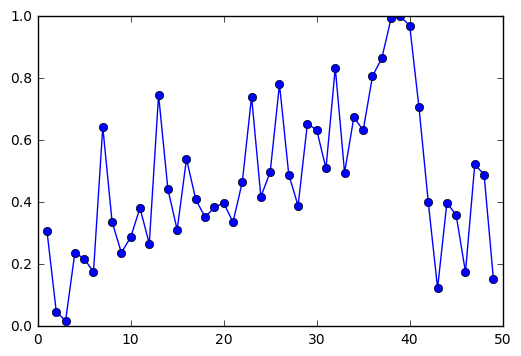

In [6]:
plt.plot(intens[-100], "-o")

In [7]:
# Random forest trained on 40 features
wl, intens = wl[5:45].copy(), intens[:,5:45].copy()

In [13]:
intens[np.isnan(intens)] = 0
np.amax(intens)

1.0046168245615563

## Load trained RF model (the @anchor from rnd_forest40ch_clean_and_3noise.ipynb)

In [9]:
import _pickle
with open(my_rf_path+my_file, 'rb') as f:
    rf = _pickle.load(f)

In [16]:
T_predict = rf.predict(intens)

In [19]:
T_predict

array([[4240.06, 2006.  ],
       [5958.24, 2002.  ],
       [1353.12, 2111.  ],
       ...,
       [1250.7 , 2243.  ],
       [1071.3 , 2153.  ],
       [5665.08, 2035.  ]])

## Results
### Trot

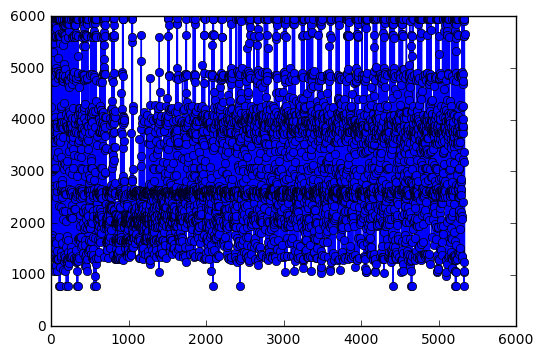

In [21]:
# Trot
plt.plot(T_predict[:,0],"-o")

In [46]:
T_predict[:,0].shape/(coord[-1,1]+1)

array([46.])

In [47]:
Z = T_predict[:,0].reshape(int(T_predict[:,0].shape/(coord[-1,1]+1)),-1)
Z

array([[4240.06, 5958.24, 1353.12, ..., 5950.8 , 1159.04,  788.22],
       [3872.08, 4842.72, 5488.36, ..., 4894.54, 4745.88, 1339.62],
       [3005.42, 5863.3 , 4150.46, ..., 5954.64, 1272.96, 4084.4 ],
       ...,
       [3921.18, 3647.72, 1108.7 , ..., 1060.46, 1290.96, 5950.16],
       [5951.02, 2013.54, 5965.44, ..., 5946.34,  788.22, 5951.06],
       [4914.3 , 5333.72, 1063.32, ..., 1250.7 , 1071.3 , 5665.08]])

In [48]:
# http://jeffskinnerbox.me/notebooks/matplotlib-2d-and-3d-plotting-in-ipython.html
phi_m = np.linspace(0, coord[-1,0], int(coord[-1,0]+1))
phi_p = np.linspace(0, coord[-1,1], int(coord[-1,1]+1))
X,Y = np.meshgrid(phi_p, phi_m)
X,Y

(array([[  0.,   1.,   2., ..., 113., 114., 115.],
        [  0.,   1.,   2., ..., 113., 114., 115.],
        [  0.,   1.,   2., ..., 113., 114., 115.],
        ...,
        [  0.,   1.,   2., ..., 113., 114., 115.],
        [  0.,   1.,   2., ..., 113., 114., 115.],
        [  0.,   1.,   2., ..., 113., 114., 115.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 2.,  2.,  2., ...,  2.,  2.,  2.],
        ...,
        [43., 43., 43., ..., 43., 43., 43.],
        [44., 44., 44., ..., 44., 44., 44.],
        [45., 45., 45., ..., 45., 45., 45.]]))

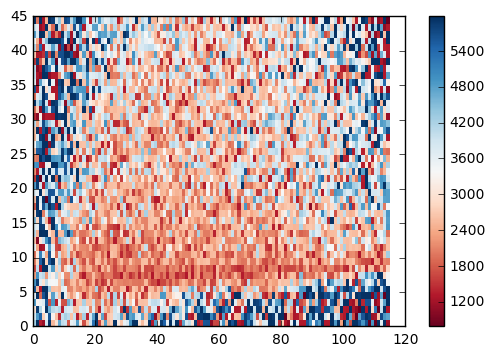

In [49]:
fig, ax = plt.subplots()

p = ax.pcolor(X, Y, Z, cmap=plt.cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
cb = fig.colorbar(p)

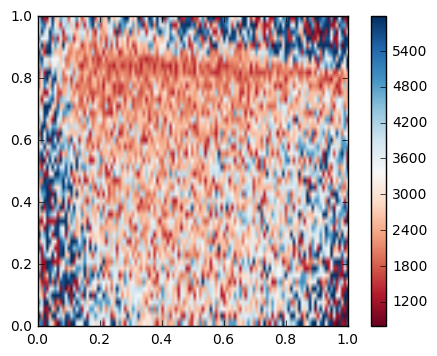

In [50]:
fig, ax = plt.subplots()

im = plt.imshow(Z, cmap=plt.cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max(), extent=[0, 1, 0, 1])
im.set_interpolation('bilinear')

cb = fig.colorbar(im)

### Tvib

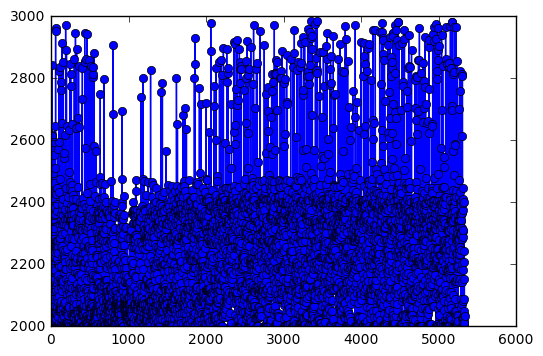

In [51]:
# Tvib
plt.plot(T_predict[:,1],"-o")

In [53]:
x1 = np.linspace(0, coord[-1,1], int(coord[-1,1]+1))
y1 = np.linspace(0, coord[-1,0], int(coord[-1,0]+1))
X,Y = np.meshgrid(x1, y1)

Z = T_predict[:,1].reshape(int(T_predict[:,1].shape/(coord[-1,1]+1)),-1)

X,Y,Z

(array([[  0.,   1.,   2., ..., 113., 114., 115.],
        [  0.,   1.,   2., ..., 113., 114., 115.],
        [  0.,   1.,   2., ..., 113., 114., 115.],
        ...,
        [  0.,   1.,   2., ..., 113., 114., 115.],
        [  0.,   1.,   2., ..., 113., 114., 115.],
        [  0.,   1.,   2., ..., 113., 114., 115.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 2.,  2.,  2., ...,  2.,  2.,  2.],
        ...,
        [43., 43., 43., ..., 43., 43., 43.],
        [44., 44., 44., ..., 44., 44., 44.],
        [45., 45., 45., ..., 45., 45., 45.]]),
 array([[2006., 2002., 2111., ..., 2000., 2328., 2050.],
        [2273., 2073., 2152., ..., 2061., 2358., 2112.],
        [2633., 2009., 2286., ..., 2003., 2166., 2317.],
        ...,
        [2251., 2493., 2101., ..., 2251., 2160., 2003.],
        [2003., 2011., 2009., ..., 2000., 2050., 2003.],
        [2287., 2437., 2238., ..., 2243., 2153., 2035.]]))

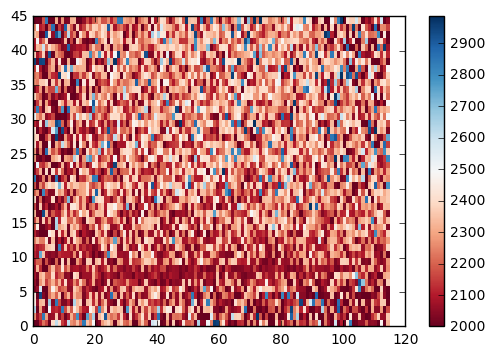

In [54]:
fig, ax = plt.subplots()

p = ax.pcolor(X, Y, Z, cmap=plt.cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
cb = fig.colorbar(p)

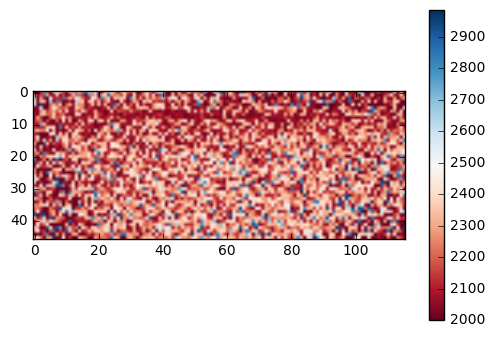

In [58]:
fig, ax = plt.subplots()

im = plt.imshow(Z, cmap=plt.cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
im.set_interpolation('bilinear')

cb = fig.colorbar(im)

## Save results

In [60]:
# https://stackoverflow.com/questions/20928136/input-and-output-numpy-arrays-to-h5py
import h5py

with h5py.File(raw_spectra_name+'.h5', 'w') as hf:
    hf.create_dataset("wavelengths",  data=wl)
    hf.create_dataset("intensity",  data=intens)
    hf.create_dataset("coordinates",  data=coord)
    hf.create_dataset("T_predict",  data=T_predict)


## Read Results

In [61]:
with h5py.File(raw_spectra_name+'.h5', 'r') as hf:
    wl5 = hf['wavelengths'][:]
    intens5 = hf['intensity'][:]
    coord5 = hf['coordinates'][:]
    T_predict5 = hf['T_predict'][:]
    

In [63]:
wl5.shape, intens5.shape, coord5.shape, T_predict.shape

((40,), (5336, 40), (5336, 2), (5336, 2))